In [22]:
import cirq
import numpy as np

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

# Quantum Compression

Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of  similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue. (Draft, info pulled from paper)

In [24]:
qubits = cirq.LineQubit.range(3)
first, second, third = qubits
circuit = cirq.Circuit()

# Circuit

In [25]:
circuit.append([cirq.H(first), cirq.H(third)])
circuit.append([cirq.S(first)**-1, cirq.CNOT(control=third, target=second)])
circuit.append([cirq.H(first)])
circuit    

0: ───H───S^-1───H───

1: ───────X──────────
          │
2: ───H───@──────────

In [26]:
circuit.append([cirq.CNOT(control=first, target=second)])
circuit.append([cirq.Z(first)])
circuit.append([cirq.H(first)])
circuit.append([cirq.CNOT(control=first, target=second)])
circuit.append([cirq.S(first), cirq.T(second)])
circuit.append([cirq.H(first), cirq.Z(second)])
circuit.append([cirq.CNOT(control=first, target=second)])
circuit.append([cirq.T(first)])
circuit.append([cirq.H(first)])
circuit.append([cirq.T(first)])
circuit


# S-H-T * 4 on first qubit
for _ in range(4):
    circuit.append([cirq.S(first)])
    circuit.append([cirq.H(first)])
    circuit.append([cirq.T(first)])
circuit

    
# H T H T-1 H T-1 H T Z H Measurement
circuit.append([cirq.H(first)])
circuit.append([cirq.T(first)])
circuit.append([cirq.H(first)])
circuit.append([cirq.T(first)**-1])
circuit.append([cirq.H(first)])
circuit.append([cirq.T(first)**-1])
circuit.append([cirq.H(first)])
circuit.append([cirq.T(first)])
circuit.append([cirq.Z(first)])
circuit.append([cirq.H(first)])
circuit

# Measure in the Y basis
circuit.append([cirq.S(first)**-1])
circuit.append([cirq.H(first)])
circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───S^-1───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

# Measurement

Measure in the Y basis

In [29]:
reps = 100

simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)
res = wave_function.final_state
print(res)
#assuming dictionary ordering
pos = (sum([np.absolute(i)**2 for i in res[0:4]]))
neg = (sum([np.absolute(i)**2 for i in res[4:8]]))
print("expected value: ", pos - neg)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.28471065-0.41102272j  0.41102272-0.28471065j
 -0.08931614+0.4919578j   0.4919578 +0.08931614j]
expected value:  -0.9999993443490158


In [31]:
circuit.append([cirq.measure(first, key='x')])
results = simulator.run(circuit, repetitions=reps)

In [14]:
from collections import OrderedDict

hist = OrderedDict(results.histogram(key='x'))
for k in hist:
    v = hist[k]
    hist[k] = v/reps
    
print(hist)

# 0 -> +1
# 1 -> -1
# hist[-1] = hist[1]
# hist[1] = hist[0]
# del hist[0]
# hist

OrderedDict([(1, 0.86), (0, 0.14)])


In [15]:
wave_function

measurements: (no measurements)
output vector: (-0.107-0.184j)|000⟩ + (0.184-0.107j)|001⟩ + (-0.055+0.206j)|010⟩ + (0.206+0.055j)|011⟩ + (-0.258-0.372j)|100⟩ + (0.372-0.258j)|101⟩ + (-0.081+0.445j)|110⟩ + (0.445+0.081j)|111⟩

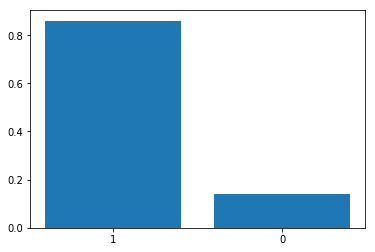

In [16]:
import matplotlib.pyplot as plt 

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

In [17]:
exp_val = hist[0] * 1 + hist[1] * -1
exp_val

-0.72